# Autoencoder

Un modelo de autoencoder se descompone a su vez en dos modelos de redes neuronales. La primera, el encoder, tiene el objetivo de comprimir la información de los datos; la segunda, el decoder, trata de reconstruir la información original a partir de los datos comprimidos. 

La motivación para el estudio de un encoder en este problema es:
1. Una vez entrenado el autoencoder completo, podemos separar las dos redes neuronales subyacentes y utilizar la parte encoder (con alguna modificación) para probar su rendimiento como modelo de red de clasificación.
2. Para los datos de test proporcionados por la competición de Kaggle (no se dispone de la clasificación verdadera), el encoder puede ayudar a "recrear" sus etiquetas.

### Preparación de los datos

In [1]:
# Estructuras de datos
import pandas as pd
import numpy as np

# Model
import tensorflow as tf
import keras
from keras import layers, models

# Cargar los datos
from data_and_submissions import *

# Métodos para los entrenamientos con CV
from train_cv_methods import *

In [2]:
X_train, X_test, y_train, y_test, test_kaggle = load_data()
print("Tamaño del dataset de train:", X_train.shape)
print("Tamaño del dataset de test:", X_test.shape)

Tamaño del dataset de train: (68, 410)
Tamaño del dataset de test: (18, 410)


In [3]:
X_train_tot = pd.concat((X_train, X_test), axis=0)
X_train_tot.shape

(86, 410)

### Modelo

Para crear el autoencoder, se utilizarán redes simétricas.

In [4]:
tf.keras.utils.set_random_seed(0)

# Definir y entrenar el modelo
input_layer = layers.Input(shape=(410,))
# Capas red encoder
encoded = layers.Dense(200, activation="relu")(input_layer)
encoded = layers.Dense(100, activation="relu")(encoded)
encoded = layers.Dense(50, activation="relu")(encoded)
# Capas red decoder
decoded = layers.Dense(50, activation="relu")(encoded)
decoded = layers.Dense(100, activation="relu")(decoded)
decoded = layers.Dense(200, activation="relu")(decoded)
decoded = layers.Dense(410, activation="linear")(decoded)

# Autoencoder
autoencoder = models.Model(input_layer, decoded)

# Compilar y entrenar el autoencoder
autoencoder.compile(optimizer="rmsprop", loss="mse")
autoencoder.fit(test_kaggle, test_kaggle, epochs=100, batch_size=64, validation_split=0.25)

Epoch 1/100
1404/1404 [==============================] - 7s 4ms/step - loss: 0.1411 - val_loss: 0.1272
Epoch 2/100
1404/1404 [==============================] - 5s 4ms/step - loss: 0.1208 - val_loss: 0.1164
Epoch 3/100
1404/1404 [==============================] - 5s 4ms/step - loss: 0.1154 - val_loss: 0.1174
Epoch 4/100
1404/1404 [==============================] - 5s 4ms/step - loss: 0.1136 - val_loss: 0.1120
Epoch 5/100
1404/1404 [==============================] - 5s 4ms/step - loss: 0.1108 - val_loss: 0.1107
Epoch 6/100
1404/1404 [==============================] - 7s 5ms/step - loss: 0.1083 - val_loss: 0.1078
Epoch 7/100
1404/1404 [==============================] - 6s 4ms/step - loss: 0.1074 - val_loss: 0.1093
Epoch 8/100
1404/1404 [==============================] - 6s 4ms/step - loss: 0.1063 - val_loss: 0.1052
Epoch 9/100
1404/1404 [==============================] - 6s 4ms/step - loss: 0.1047 - val_loss: 0.1057
Epoch 10/100
1404/1404 [==============================] - 6s 4ms/step - l

Epoch 80/100
1404/1404 [==============================] - 6s 4ms/step - loss: 0.0937 - val_loss: 0.0939
Epoch 81/100
1404/1404 [==============================] - 7s 5ms/step - loss: 0.0937 - val_loss: 0.0938
Epoch 82/100
1404/1404 [==============================] - 7s 5ms/step - loss: 0.0937 - val_loss: 0.0942
Epoch 83/100
1404/1404 [==============================] - 7s 5ms/step - loss: 0.0936 - val_loss: 0.0938
Epoch 84/100
1404/1404 [==============================] - 6s 5ms/step - loss: 0.0936 - val_loss: 0.0944
Epoch 85/100
1404/1404 [==============================] - 6s 4ms/step - loss: 0.0936 - val_loss: 0.0940
Epoch 86/100
1404/1404 [==============================] - 6s 4ms/step - loss: 0.0936 - val_loss: 0.0941
Epoch 87/100
1404/1404 [==============================] - 6s 5ms/step - loss: 0.0935 - val_loss: 0.0933
Epoch 88/100
1404/1404 [==============================] - 7s 5ms/step - loss: 0.0935 - val_loss: 0.0938
Epoch 89/100
1404/1404 [==============================] - 6s 4ms

In [5]:
autoencoder.save("autoencoder.h5")

In [4]:
autoencoder = models.load_model("autoencoder.h5")

Evaluación del autoencoder, se utilizarán métricas como:

* MSE = $\frac{1}{n} \sum_{i=1}^{n} (Y_{true}^{i} - Y_{pred}^{i})^{2}$
* MAPE = $\frac{1}{n} \sum_{i=1}^{n} \left| \frac{Y_{true}^{i} - Y_{pred}^{i}}{Y_{true}^{i}} \right|$

donde $Y_{true}$ es el valor real, $Y_{pred}$ el valor de la predicción y $n$ el número de predicciones.

La anterior fórmula realiza el cálculo para dos "listas de valores", por ejemplo, podemos calcular el error MAPE por muestra o por feature. Para el valor del error de la predicción total, se debe promediar el error obtenido para todas las filas/columnas.

In [5]:
from keras.losses import MeanSquaredError, MeanAbsolutePercentageError

# Definición de las métricas
mse = MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
mape = MeanAbsolutePercentageError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

In [6]:
# ERROR SOBRE X_train_tot (etiquetados)
X_train_tot_pred = autoencoder.predict(X_train_tot)

print("MAPE:", mape(X_train_tot, X_train_tot_pred))
print("MSE:", mse(X_train_tot, X_train_tot_pred))

MAPE: tf.Tensor(315.31876, shape=(), dtype=float32)
MSE: tf.Tensor(0.08369573, shape=(), dtype=float32)


El error es bastante elevado. Vamos a comprobar cómo se distribuyen los valores de error MAPE en cada variable.

In [7]:
mape_tmp = np.abs((X_train_tot - X_train_tot_pred) / X_train_tot)
mape_tmp.shape

(86, 410)

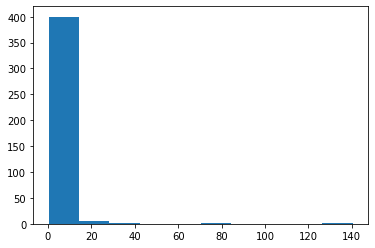

In [8]:
import matplotlib.pyplot as plt

plt.hist(mape_tmp.mean(axis=0))
plt.show()

In [9]:
(mape_tmp.mean(axis=0) < 1).mean()

0.08292682926829269

In [10]:
mape_tmp.mean(axis=0).shape

(410,)

La anterior expresión indica que únicamente en torno al 8% de las variables en X_train, tienen un error de MAPE que es inferior al 100%. 

Podíamos pensar que la primera barra en el anterior histograma esconde una gran concentración de valores con errores inferiores al 100% y que el valor final queda desviado por aquellos con valores muy superiores, sin embargo, esta última comprobación lo desmiente.

In [11]:
# ERROR SOBRE test_kaggle (no etiquetados)
test_kaggle_pred = autoencoder.predict(test_kaggle)

print("MAPE:", mape(test_kaggle, test_kaggle_pred))
print("MSE:", mse(test_kaggle, test_kaggle_pred))

MAPE: tf.Tensor(426.45328, shape=(), dtype=float32)
MSE: tf.Tensor(0.09347953, shape=(), dtype=float32)


Sobre el conjunto de entrenamiento ``test_kaggle``, vamos a seleccionar 100 veces 86 muestras y a promediar los valores de desviación típica.

In [12]:
samples_num = 100
mape_samples = []

for _ in range(samples_num):
    
    args = np.random.choice(a=np.arange(0, test_kaggle.shape[0]), size=86, replace=False)

    test_kaggle_reduc = test_kaggle.iloc[args, :]

    y_pred_kaggle_reduc = autoencoder.predict(test_kaggle_reduc)
    tmp_mape = mape(test_kaggle_reduc, y_pred_kaggle_reduc)
    mape_samples.append(tmp_mape)
    
print(f'MAPE: {np.mean(mape_samples)} +- {np.std(mape_samples)}')

MAPE: 415.7068786621094 +- 354.8747253417969


El valor del MAPE en ``test_kaggle`` es también muy elevado, con grandes desviaciones entre muestras.

___

Pasamos al problema de clasificación.

In [13]:
encoder_input = layers.Input(shape=(410,))
encoder = encoder_input
for layer in autoencoder.layers[1:4]:
    encoder = layer(encoder)
encoder = models.Model(inputs=encoder_input, outputs=encoder)

In [14]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 410)]             0         
                                                                 
 dense (Dense)               (None, 200)               82200     
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
Total params: 107,350
Trainable params: 107,350
Non-trainable params: 0
_________________________________________________________________


Una vez hemos entrenado la red autoencoder, el componente encoder de la misma ya contará con unos pesos entrenados con el objetivo de comprimir los datos de entrada. Por tanto, podemos considerar de manera independiente esta red encoder y volver a entrenarla como una red para clasificación, con la ventaja de que se parte de un modelo inicializado no con unos pesos aleatorios, sino unos pesos optimizados para un problema similar.

Para hacer esto es necesario añadir previamente una capa final de clasificación.

In [15]:
encoder_classification = models.Sequential()
encoder_classification.add(encoder)
encoder_classification.add(layers.Dense(1, activation="sigmoid"))

Incluso es posible congelar los pesos de todas las capas del encoder original, ya entrenados "para un problema similar", y modificar solamente los pesos de la capa final de clasificación, utilizando los datos de train (etiquetados).

In [16]:
tf.keras.utils.set_random_seed(0)

# Congelar los pesos de todas las capas a excepción de la última
for layer in encoder_classification.layers[:-1]:
    layer.trainable = False

# Entrenar el modelo
encoder_classification.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
encoder_classification.fit(X_train, y_train, epochs=100, validation_split=0.25)

# Precisión en partición de test
loss, accuracy = encoder_classification.evaluate(X_test, y_test)
print("Accuracy: {:0.2f}%".format(accuracy * 100))

Epoch 1/100
2/2 [==============================] - 3s 284ms/step - loss: 0.7143 - acc: 0.4902 - val_loss: 0.7079 - val_acc: 0.3529
Epoch 2/100
2/2 [==============================] - 0s 33ms/step - loss: 0.7089 - acc: 0.4314 - val_loss: 0.7043 - val_acc: 0.4118
Epoch 3/100
2/2 [==============================] - 0s 31ms/step - loss: 0.7057 - acc: 0.4510 - val_loss: 0.7020 - val_acc: 0.4118
Epoch 4/100
2/2 [==============================] - 0s 30ms/step - loss: 0.7036 - acc: 0.4706 - val_loss: 0.6999 - val_acc: 0.4706
Epoch 5/100
2/2 [==============================] - 0s 28ms/step - loss: 0.7019 - acc: 0.5098 - val_loss: 0.6981 - val_acc: 0.4706
Epoch 6/100
2/2 [==============================] - 0s 29ms/step - loss: 0.7001 - acc: 0.4902 - val_loss: 0.6968 - val_acc: 0.4706
Epoch 7/100
2/2 [==============================] - 0s 35ms/step - loss: 0.7013 - acc: 0.4706 - val_loss: 0.6965 - val_acc: 0.4706
Epoch 8/100
2/2 [==============================] - 0s 30ms/step - loss: 0.6985 - acc: 0.4

2/2 [==============================] - 0s 30ms/step - loss: 0.6757 - acc: 0.5882 - val_loss: 0.6812 - val_acc: 0.6471
Epoch 64/100
2/2 [==============================] - 0s 27ms/step - loss: 0.6752 - acc: 0.5882 - val_loss: 0.6811 - val_acc: 0.6471
Epoch 65/100
2/2 [==============================] - 0s 26ms/step - loss: 0.6747 - acc: 0.6078 - val_loss: 0.6810 - val_acc: 0.6471
Epoch 66/100
2/2 [==============================] - 0s 24ms/step - loss: 0.6743 - acc: 0.5882 - val_loss: 0.6810 - val_acc: 0.6471
Epoch 67/100
2/2 [==============================] - 0s 26ms/step - loss: 0.6739 - acc: 0.5882 - val_loss: 0.6808 - val_acc: 0.6471
Epoch 68/100
2/2 [==============================] - 0s 26ms/step - loss: 0.6736 - acc: 0.5882 - val_loss: 0.6807 - val_acc: 0.6471
Epoch 69/100
2/2 [==============================] - 0s 24ms/step - loss: 0.6732 - acc: 0.5882 - val_loss: 0.6806 - val_acc: 0.6471
Epoch 70/100
2/2 [==============================] - 0s 26ms/step - loss: 0.6729 - acc: 0.6078 - 

Tras unas pocas iteraciones, descongelamos todas las capas y hacemos unas pocas épocas más entrenando y actualizando los pesos para el modelo completo.

In [17]:
tf.keras.utils.set_random_seed(0)

# Descongelar los pesos de todas las capas a excepción de la última
for layer in encoder_classification.layers[:-1]:
    layer.trainable = True

# Entrenar el modelo
encoder_classification.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
encoder_classification.fit(X_train, y_train, epochs=15, validation_split=0.25)

# Precisión en partición de test
loss, accuracy_encoder_classification = encoder_classification.evaluate(X_test, y_test)
print("Accuracy: {:0.2f}%".format(accuracy_encoder_classification * 100))

Epoch 1/15
2/2 [==============================] - 1s 144ms/step - loss: 0.6560 - acc: 0.7059 - val_loss: 0.6500 - val_acc: 0.7059
Epoch 2/15
2/2 [==============================] - 0s 30ms/step - loss: 0.5549 - acc: 0.8627 - val_loss: 0.6373 - val_acc: 0.7059
Epoch 3/15
2/2 [==============================] - 0s 31ms/step - loss: 0.4569 - acc: 0.8824 - val_loss: 0.6135 - val_acc: 0.7647
Epoch 4/15
2/2 [==============================] - 0s 33ms/step - loss: 0.3606 - acc: 0.9412 - val_loss: 0.6048 - val_acc: 0.7059
Epoch 5/15
2/2 [==============================] - 0s 30ms/step - loss: 0.2737 - acc: 1.0000 - val_loss: 0.6244 - val_acc: 0.7059
Epoch 6/15
2/2 [==============================] - 0s 25ms/step - loss: 0.2036 - acc: 1.0000 - val_loss: 0.6248 - val_acc: 0.6471
Epoch 7/15
2/2 [==============================] - 0s 28ms/step - loss: 0.1889 - acc: 0.9608 - val_loss: 0.6251 - val_acc: 0.5294
Epoch 8/15
2/2 [==============================] - 0s 34ms/step - loss: 0.1302 - acc: 1.0000 - va

In [18]:
encoder_classification.save("encoder.h5")

In [58]:
y_pred_pre_train_encoder = encoder_classification.predict(test_kaggle)
y_pred_pre_train_encoder = np.around(y_pred_pre_train_encoder, decimals=0).ravel()

create_submission(y_pred_pre_train_encoder, "NN_pre_train_autoencoder1")

(119748, 2)


El objetivo es poder comparar con la misma configuración de red que la encoder sin utilizar los pesos pre-entrenados de esta y observar si hay mejora.

In [19]:
tf.keras.utils.set_random_seed(0) # Reproducibilidad de resultados

# Definir y entrenar el modelo
no_pre_train = models.Sequential()
no_pre_train.add(layers.Dense(200, activation="relu", input_shape=(410,)))
no_pre_train.add(layers.Dense(100, activation="relu"))
no_pre_train.add(layers.Dense(50, activation="relu"))
no_pre_train.add(layers.Dense(1, activation="sigmoid"))

no_pre_train.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["acc"])
no_pre_train.fit(X_train, y_train, epochs=115, validation_split=0.25)

# Precisión en partición de test
loss, accuracy_no_pre_train = no_pre_train.evaluate(X_test, y_test)
print("Accuracy: {:0.2f}%".format(accuracy_no_pre_train * 100))

Epoch 1/115
2/2 [==============================] - 1s 146ms/step - loss: 0.6693 - acc: 0.5098 - val_loss: 0.6605 - val_acc: 0.5882
Epoch 2/115
2/2 [==============================] - 0s 43ms/step - loss: 0.4618 - acc: 0.8824 - val_loss: 0.6751 - val_acc: 0.7059
Epoch 3/115
2/2 [==============================] - 0s 38ms/step - loss: 0.3048 - acc: 0.9608 - val_loss: 0.6953 - val_acc: 0.7059
Epoch 4/115
2/2 [==============================] - 0s 40ms/step - loss: 0.1893 - acc: 0.9804 - val_loss: 0.7126 - val_acc: 0.7647
Epoch 5/115
2/2 [==============================] - 0s 36ms/step - loss: 0.1170 - acc: 1.0000 - val_loss: 0.7912 - val_acc: 0.7647
Epoch 6/115
2/2 [==============================] - 0s 40ms/step - loss: 0.0785 - acc: 1.0000 - val_loss: 0.7260 - val_acc: 0.6471
Epoch 7/115
2/2 [==============================] - 0s 30ms/step - loss: 0.0511 - acc: 1.0000 - val_loss: 0.7264 - val_acc: 0.5294
Epoch 8/115
2/2 [==============================] - 0s 24ms/step - loss: 0.0435 - acc: 1.0

2/2 [==============================] - 0s 26ms/step - loss: 4.9681e-06 - acc: 1.0000 - val_loss: 1.4391 - val_acc: 0.8235
Epoch 63/115
2/2 [==============================] - 0s 28ms/step - loss: 4.4195e-06 - acc: 1.0000 - val_loss: 1.4541 - val_acc: 0.8235
Epoch 64/115
2/2 [==============================] - 0s 29ms/step - loss: 3.8758e-06 - acc: 1.0000 - val_loss: 1.4368 - val_acc: 0.8235
Epoch 65/115
2/2 [==============================] - 0s 25ms/step - loss: 3.4163e-06 - acc: 1.0000 - val_loss: 1.4705 - val_acc: 0.8235
Epoch 66/115
2/2 [==============================] - 0s 28ms/step - loss: 3.0136e-06 - acc: 1.0000 - val_loss: 1.4726 - val_acc: 0.8235
Epoch 67/115
2/2 [==============================] - 0s 26ms/step - loss: 2.6696e-06 - acc: 1.0000 - val_loss: 1.4833 - val_acc: 0.8235
Epoch 68/115
2/2 [==============================] - 0s 24ms/step - loss: 2.3741e-06 - acc: 1.0000 - val_loss: 1.4731 - val_acc: 0.8235
Epoch 69/115
2/2 [==============================] - 0s 27ms/step - l

In [60]:
y_pred_no_pre_train = no_pre_train.predict(test_kaggle)
y_pred_no_pre_train = np.around(y_pred_no_pre_train, decimals=0).ravel()

create_submission(y_pred_no_pre_train, "NN_no_pre_train1")

(119748, 2)


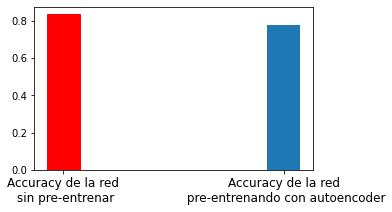

In [55]:
import matplotlib.pyplot as plt

results_acc = [accuracy_no_pre_train, accuracy_encoder_classification]
xaxis = ["Accuracy de la red\n sin pre-entrenar", "Accuracy de la red\n pre-entrenando con autoencoder"]

plt.figure(figsize=(5, 3))
barlist = plt.bar(xaxis, results_acc, width=0.15)
barlist[0].set_color("r")
plt.xticks(fontsize=12)
plt.show()

**Vamos a probar con una configuración de autoencoder más compleja**

In [20]:
tf.keras.utils.set_random_seed(0)

# Definir y entrenar el modelo
input_layer2 = layers.Input(shape=(410,))
# Capas red encoder
encoded2 = layers.Dense(300, activation="relu")(input_layer2)
encoded2 = layers.Dense(250, activation="relu")(encoded2)
encoded2 = layers.Dense(200, activation="relu")(encoded2)
encoded2 = layers.Dense(150, activation="relu")(encoded2)
encoded2 = layers.Dense(100, activation="relu")(encoded2)
encoded2 = layers.Dense(50, activation="relu")(encoded2)
# Capas red decoder
decoded2 = layers.Dense(50, activation="relu")(encoded2)
decoded2 = layers.Dense(100, activation="relu")(decoded2)
decoded2 = layers.Dense(150, activation="relu")(decoded2)
decoded2 = layers.Dense(200, activation="relu")(decoded2)
decoded2 = layers.Dense(250, activation="relu")(decoded2)
decoded2 = layers.Dense(300, activation="relu")(decoded2)
decoded2 = layers.Dense(410, activation="linear")(decoded2)

# Autoencoder
autoencoder2 = models.Model(input_layer2, decoded2)

# Compilar y entrenar el autoencoder
autoencoder2.compile(optimizer="rmsprop", loss="mse")
autoencoder2.fit(test_kaggle, test_kaggle, epochs=200, batch_size=64, validation_split=0.25)

Epoch 1/200
1404/1404 [==============================] - 13s 9ms/step - loss: 0.1778 - val_loss: 0.1727
Epoch 2/200
1404/1404 [==============================] - 11s 8ms/step - loss: 0.1672 - val_loss: 0.1634
Epoch 3/200
1404/1404 [==============================] - 12s 8ms/step - loss: 0.1604 - val_loss: 0.1585
Epoch 4/200
1404/1404 [==============================] - 11s 8ms/step - loss: 0.1564 - val_loss: 0.1551
Epoch 5/200
1404/1404 [==============================] - 12s 8ms/step - loss: 0.1532 - val_loss: 0.1525
Epoch 6/200
1404/1404 [==============================] - 12s 9ms/step - loss: 0.1508 - val_loss: 0.1500
Epoch 7/200
1404/1404 [==============================] - 12s 8ms/step - loss: 0.1485 - val_loss: 0.1478
Epoch 8/200
1404/1404 [==============================] - 12s 8ms/step - loss: 0.1468 - val_loss: 0.1475
Epoch 9/200
1404/1404 [==============================] - 12s 8ms/step - loss: 0.1458 - val_loss: 0.1473
Epoch 10/200
1404/1404 [==============================] - 11s 8m

1404/1404 [==============================] - 13s 9ms/step - loss: 0.1273 - val_loss: 0.1283
Epoch 80/200
1404/1404 [==============================] - 13s 9ms/step - loss: 0.1272 - val_loss: 0.1279
Epoch 81/200
1404/1404 [==============================] - 13s 9ms/step - loss: 0.1274 - val_loss: 0.1289
Epoch 82/200
1404/1404 [==============================] - 13s 9ms/step - loss: 0.1277 - val_loss: 0.1268
Epoch 83/200
1404/1404 [==============================] - 13s 9ms/step - loss: 0.1278 - val_loss: 0.1292
Epoch 84/200
1404/1404 [==============================] - 13s 9ms/step - loss: 0.1276 - val_loss: 0.1299
Epoch 85/200
1404/1404 [==============================] - 13s 9ms/step - loss: 0.1279 - val_loss: 0.1283
Epoch 86/200
1404/1404 [==============================] - 13s 9ms/step - loss: 0.1273 - val_loss: 0.1291
Epoch 87/200
1404/1404 [==============================] - 13s 9ms/step - loss: 0.1278 - val_loss: 0.1282
Epoch 88/200
1404/1404 [==============================] - 13s 9ms/st

1404/1404 [==============================] - 13s 9ms/step - loss: 0.1282 - val_loss: 0.1306
Epoch 157/200
1404/1404 [==============================] - 13s 9ms/step - loss: 0.1279 - val_loss: 0.1286
Epoch 158/200
1404/1404 [==============================] - 13s 9ms/step - loss: 0.1276 - val_loss: 0.1303
Epoch 159/200
1404/1404 [==============================] - 13s 9ms/step - loss: 0.1283 - val_loss: 0.1275
Epoch 160/200
1404/1404 [==============================] - 13s 9ms/step - loss: 0.1275 - val_loss: 0.1293
Epoch 161/200
1404/1404 [==============================] - 12s 9ms/step - loss: 0.1275 - val_loss: 0.1288
Epoch 162/200
1404/1404 [==============================] - 13s 9ms/step - loss: 0.1285 - val_loss: 0.1315
Epoch 163/200
1404/1404 [==============================] - 12s 9ms/step - loss: 0.1289 - val_loss: 0.1295
Epoch 164/200
1404/1404 [==============================] - 13s 9ms/step - loss: 0.1280 - val_loss: 0.1296
Epoch 165/200
1404/1404 [==============================] - 1

In [21]:
autoencoder2.save("autoencoder2.h5")

In [13]:
autoencoder2 = models.load_model("autoencoder2.h5")

In [22]:
# ERROR SOBRE X_train_tot (etiquetados)
X_train_tot_pred = autoencoder2.predict(X_train_tot)

print("MAPE:", mape(X_train_tot, X_train_tot_pred))
print("MSE:", mse(X_train_tot, X_train_tot_pred))

MAPE: tf.Tensor(367.13974, shape=(), dtype=float32)
MSE: tf.Tensor(0.121041566, shape=(), dtype=float32)


In [23]:
mape_tmp = np.abs((X_train_tot - X_train_tot_pred) / X_train_tot)
mape_tmp.shape

(86, 410)

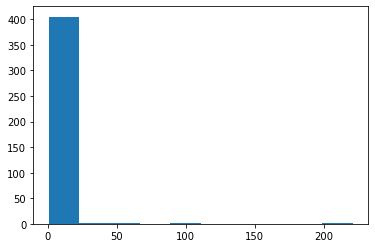

In [24]:
import matplotlib.pyplot as plt

plt.hist(mape_tmp.mean(axis=0))
plt.show()

In [25]:
(mape_tmp.mean(axis=0) < 1).mean()

0.03414634146341464

In [26]:
# ERROR SOBRE test_kaggle (no etiquetados)
test_kaggle_pred = autoencoder2.predict(test_kaggle)

print("MAPE:", mape(test_kaggle, test_kaggle_pred))
print("MSE:", mse(test_kaggle, test_kaggle_pred))

MAPE: tf.Tensor(452.5427, shape=(), dtype=float32)
MSE: tf.Tensor(0.12940164, shape=(), dtype=float32)


In [28]:
samples_num = 100
mape_samples = []

for _ in range(samples_num):
    
    args = np.random.choice(a=np.arange(0, test_kaggle.shape[0]), size=86, replace=False)

    test_kaggle_reduc = test_kaggle.iloc[args, :]

    y_pred_kaggle_reduc = autoencoder2.predict(test_kaggle_reduc)
    tmp_mape = mape(test_kaggle_reduc, y_pred_kaggle_reduc)
    mape_samples.append(tmp_mape)
    
print(f'MAPE: {np.mean(mape_samples)} +- {np.std(mape_samples)}')

MAPE: 434.28009033203125 +- 313.5392150878906


En este caso, aumentar la complejidad del autoencoder no mejora excesivamente los resultados.

Vamos a ver si se observa algún tipo de mejoría en los resultados de la red de clasificación (encoder).

In [30]:
encoder_input2 = layers.Input(shape=(410,))
encoder2 = encoder_input2
for layer in autoencoder2.layers[1:7]:
    encoder2 = layer(encoder2)
encoder2 = models.Model(inputs=encoder_input2, outputs=encoder2)

In [31]:
encoder2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 410)]             0         
                                                                 
 dense_12 (Dense)            (None, 300)               123300    
                                                                 
 dense_13 (Dense)            (None, 250)               75250     
                                                                 
 dense_14 (Dense)            (None, 200)               50200     
                                                                 
 dense_15 (Dense)            (None, 150)               30150     
                                                                 
 dense_16 (Dense)            (None, 100)               15100     
                                                                 
 dense_17 (Dense)            (None, 50)                5050

In [32]:
encoder_clasificacion2 = models.Sequential()
encoder_clasificacion2.add(encoder2)
encoder_clasificacion2.add(layers.Dense(1, activation="sigmoid"))

In [33]:
tf.keras.utils.set_random_seed(0)

# Congelar los pesos de todas las capas a excepción de la última
for layer in encoder_clasificacion2.layers[:-1]:
    layer.trainable = False

# Entrenar el modelo
encoder_clasificacion2.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
encoder_clasificacion2.fit(X_train, y_train, epochs=100, validation_split=0.25)

# Precisión en partición de test
loss, accuracy = encoder_clasificacion2.evaluate(X_test, y_test)
print("Accuracy: {:0.2f}%".format(accuracy * 100))

Epoch 1/100
2/2 [==============================] - 5s 656ms/step - loss: 1.9184 - acc: 0.5098 - val_loss: 1.2401 - val_acc: 0.7059
Epoch 2/100
2/2 [==============================] - 0s 137ms/step - loss: 1.7995 - acc: 0.5098 - val_loss: 1.1947 - val_acc: 0.6471
Epoch 3/100
2/2 [==============================] - 0s 62ms/step - loss: 1.7178 - acc: 0.5098 - val_loss: 1.1591 - val_acc: 0.6471
Epoch 4/100
2/2 [==============================] - 0s 86ms/step - loss: 1.6495 - acc: 0.5098 - val_loss: 1.1319 - val_acc: 0.5882
Epoch 5/100
2/2 [==============================] - 0s 36ms/step - loss: 1.5925 - acc: 0.5098 - val_loss: 1.1096 - val_acc: 0.5882
Epoch 6/100
2/2 [==============================] - 0s 57ms/step - loss: 1.5412 - acc: 0.5098 - val_loss: 1.0903 - val_acc: 0.6471
Epoch 7/100
2/2 [==============================] - 0s 82ms/step - loss: 1.4982 - acc: 0.5294 - val_loss: 1.0741 - val_acc: 0.6471
Epoch 8/100
2/2 [==============================] - 0s 67ms/step - loss: 1.4548 - acc: 0.

2/2 [==============================] - 0s 52ms/step - loss: 0.9591 - acc: 0.6078 - val_loss: 0.8975 - val_acc: 0.6471
Epoch 64/100
2/2 [==============================] - 0s 59ms/step - loss: 0.9556 - acc: 0.6078 - val_loss: 0.8982 - val_acc: 0.6471
Epoch 65/100
2/2 [==============================] - 0s 33ms/step - loss: 0.9516 - acc: 0.6078 - val_loss: 0.8933 - val_acc: 0.6471
Epoch 66/100
2/2 [==============================] - 0s 38ms/step - loss: 0.9473 - acc: 0.6078 - val_loss: 0.8881 - val_acc: 0.6471
Epoch 67/100
2/2 [==============================] - 0s 35ms/step - loss: 0.9457 - acc: 0.6078 - val_loss: 0.8821 - val_acc: 0.6471
Epoch 68/100
2/2 [==============================] - 0s 36ms/step - loss: 0.9387 - acc: 0.6078 - val_loss: 0.8799 - val_acc: 0.6471
Epoch 69/100
2/2 [==============================] - 0s 35ms/step - loss: 0.9348 - acc: 0.6078 - val_loss: 0.8788 - val_acc: 0.6471
Epoch 70/100
2/2 [==============================] - 0s 30ms/step - loss: 0.9318 - acc: 0.6078 - 

In [34]:
tf.keras.utils.set_random_seed(0)

# Descongelar los pesos de todas las capas a excepción de la última
for layer in encoder_clasificacion2.layers[:-1]:
    layer.trainable = True

# Entrenar el modelo
encoder_clasificacion2.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
encoder_clasificacion2.fit(X_train, y_train, epochs=15, validation_split=0.25)

# Precisión en partición de test
loss, accuracy_encoder_clasificacion2 = encoder_clasificacion2.evaluate(X_test, y_test)
print("Accuracy: {:0.2f}%".format(accuracy_encoder_clasificacion2 * 100))

Epoch 1/15
2/2 [==============================] - 12s 1s/step - loss: 0.8294 - acc: 0.6078 - val_loss: 0.8819 - val_acc: 0.4706
Epoch 2/15
2/2 [==============================] - 1s 363ms/step - loss: 0.9482 - acc: 0.5882 - val_loss: 0.9035 - val_acc: 0.5882
Epoch 3/15
2/2 [==============================] - 0s 66ms/step - loss: 0.5651 - acc: 0.7451 - val_loss: 0.7633 - val_acc: 0.6471
Epoch 4/15
2/2 [==============================] - 0s 65ms/step - loss: 0.3117 - acc: 0.8431 - val_loss: 0.7735 - val_acc: 0.6471
Epoch 5/15
2/2 [==============================] - 0s 60ms/step - loss: 0.2729 - acc: 0.8431 - val_loss: 0.7867 - val_acc: 0.6471
Epoch 6/15
2/2 [==============================] - 0s 59ms/step - loss: 0.2737 - acc: 0.8824 - val_loss: 0.7244 - val_acc: 0.6471
Epoch 7/15
2/2 [==============================] - 0s 41ms/step - loss: 0.2190 - acc: 0.9412 - val_loss: 0.9827 - val_acc: 0.4706
Epoch 8/15
2/2 [==============================] - 0s 30ms/step - loss: 0.2071 - acc: 0.9412 - val

In [35]:
encoder_clasificacion2.save("encoder2.h5")

In [62]:
y_pred_pre_train_encoder2 = encoder_clasificacion2.predict(test_kaggle)
y_pred_pre_train_encoder2 = np.around(y_pred_pre_train_encoder2, decimals=0).ravel()

create_submission(y_pred_pre_train_encoder2, "NN_pre_train_autoencoder2")

(119748, 2)


Red sin pre-entrenar

In [36]:
tf.keras.utils.set_random_seed(0) # Reproducibilidad de resultados

# Definir y entrenar el modelo
no_pre_train2 = models.Sequential()
no_pre_train2.add(layers.Dense(300, activation="relu", input_shape=(410,)))
no_pre_train2.add(layers.Dense(250, activation="relu"))
no_pre_train2.add(layers.Dense(200, activation="relu"))
no_pre_train2.add(layers.Dense(150, activation="relu"))
no_pre_train2.add(layers.Dense(100, activation="relu"))
no_pre_train2.add(layers.Dense(50, activation="relu"))
no_pre_train2.add(layers.Dense(1, activation="sigmoid"))

no_pre_train2.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["acc"])
no_pre_train2.fit(X_train, y_train, epochs=115, validation_split=0.25)

# Precisión en partición de test
loss, accuracy_no_pre_train2 = no_pre_train2.evaluate(X_test, y_test)
print("Accuracy: {:0.2f}%".format(accuracy_no_pre_train2 * 100))

Epoch 1/115
2/2 [==============================] - 5s 1s/step - loss: 0.6886 - acc: 0.5098 - val_loss: 0.6569 - val_acc: 0.5882
Epoch 2/115
2/2 [==============================] - 0s 60ms/step - loss: 0.6410 - acc: 0.5294 - val_loss: 0.6890 - val_acc: 0.5882
Epoch 3/115
2/2 [==============================] - 0s 141ms/step - loss: 0.5060 - acc: 0.7647 - val_loss: 0.7015 - val_acc: 0.7059
Epoch 4/115
2/2 [==============================] - 1s 106ms/step - loss: 0.2672 - acc: 0.9216 - val_loss: 1.0483 - val_acc: 0.7059
Epoch 5/115
2/2 [==============================] - 0s 138ms/step - loss: 0.2531 - acc: 0.9216 - val_loss: 0.7821 - val_acc: 0.7647
Epoch 6/115
2/2 [==============================] - 0s 43ms/step - loss: 0.0724 - acc: 1.0000 - val_loss: 0.8761 - val_acc: 0.7647
Epoch 7/115
2/2 [==============================] - 0s 211ms/step - loss: 0.0246 - acc: 1.0000 - val_loss: 0.9357 - val_acc: 0.7647
Epoch 8/115
2/2 [==============================] - 0s 68ms/step - loss: 0.0103 - acc: 1.

2/2 [==============================] - 0s 29ms/step - loss: 5.5016e-07 - acc: 1.0000 - val_loss: 2.2357 - val_acc: 0.7647
Epoch 63/115
2/2 [==============================] - 0s 19ms/step - loss: 4.9145e-07 - acc: 1.0000 - val_loss: 2.2501 - val_acc: 0.7647
Epoch 64/115
2/2 [==============================] - 0s 163ms/step - loss: 4.3842e-07 - acc: 1.0000 - val_loss: 2.2545 - val_acc: 0.7647
Epoch 65/115
2/2 [==============================] - 0s 74ms/step - loss: 3.9269e-07 - acc: 1.0000 - val_loss: 2.2677 - val_acc: 0.7647
Epoch 66/115
2/2 [==============================] - 0s 52ms/step - loss: 3.5123e-07 - acc: 1.0000 - val_loss: 2.2821 - val_acc: 0.7647
Epoch 67/115
2/2 [==============================] - 0s 35ms/step - loss: 3.1365e-07 - acc: 1.0000 - val_loss: 2.2962 - val_acc: 0.7647
Epoch 68/115
2/2 [==============================] - 0s 52ms/step - loss: 2.7883e-07 - acc: 1.0000 - val_loss: 2.3075 - val_acc: 0.7647
Epoch 69/115
2/2 [==============================] - 0s 66ms/step - 

In [63]:
y_pred_no_pre_train2 = no_pre_train2.predict(test_kaggle)
y_pred_no_pre_train2 = np.around(y_pred_no_pre_train2, decimals=0).ravel()

create_submission(y_pred_no_pre_train2, "NN_no_pre_train2")

(119748, 2)


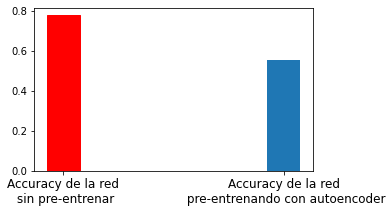

In [56]:
import matplotlib.pyplot as plt

results_acc = [accuracy_no_pre_train2, accuracy_encoder_clasificacion2]
xaxis = ["Accuracy de la red\n sin pre-entrenar", "Accuracy de la red\n pre-entrenando con autoencoder"]

plt.figure(figsize=(5, 3))
barlist = plt.bar(xaxis, results_acc, width=0.15)
barlist[0].set_color("r")
plt.xticks(fontsize=12)
plt.show()